# Multiwavelet spike detection dashboard

In [169]:
import numpy as np
import xarray as xr
import pandas as pd

# Loading big matlab files 
import mat73

# Signal processing 
import scipy.signal as ssignal

# dashboard
import panel as pn
from panel.interact import fixed
import param

# plotting 
import matplotlib.pyplot as plt
import sciplotlib.polish as splpolish 
import sciplotlib.style as splstyle

import os 
import glob

import h5py
# For downloading df to csv 
from io import StringIO

# analysis 
import detect_spikes as dspikes

# Datashader and holoviz for large plots 
from holoviews.operation.datashader import datashade
import holoviews as hv
import datashader as ds

# PCA 
from sklearn.decomposition import PCA

pn.extension()

# The dashboard

In [2]:
load_file_path = '/home/timsit/mecp2/Matlab_Analysis/analysis_functions_ts/spikeDetection/MPT200209_3A_DIV12_6_multiwavelet.mat'
multiwavelet_dat = mat73.loadmat(load_file_path)

In [3]:
multiwavelet_dat['pre_TTX_mea_spike_struct']

{'channel_12': {'bior1p3': array([2741505., 2748775., 2819565., ..., 7499498., 7499730., 7499872.]),
  'bior1p5': array([2741505., 2748776., 2819566., ..., 7499498., 7499734., 7499871.]),
  'db2': array([ 661109., 2741508., 2748778., ..., 7499503., 7499732., 7499874.]),
  'db3': array([2741510., 2748780., 2819570., ..., 7499501., 7499736., 7499875.]),
  'haar': array([2741506., 2748775., 2819565., ..., 7499279., 7499356., 7499730.]),
  'sym2': array([ 661109., 2741508., 2748778., ..., 7499503., 7499732., 7499874.])},
 'channel_13': {'bior1p3': array([2327094., 2741506., 2819570., ..., 7499725., 7499902., 7499945.]),
  'bior1p5': array([1365796., 1969772., 2327093., ..., 7499404., 7499725., 7499901.]),
  'db2': array([1082777., 1365795., 1969773., ..., 7499728., 7499900., 7499943.]),
  'db3': array([1365794., 1969772., 2741510., ..., 7499731., 7499899., 7499942.]),
  'haar': array([2327094., 2741506., 2819571., ..., 7499361., 7499410., 7499726.]),
  'sym2': array([1082777., 1365795., 19

In [88]:
channel_names = multiwavelet_dat['pre_TTX_mea_spike_struct']['channel_names']

In [10]:
def realign_spikes(channel_trace, spike_frames, alignment_duration_sec=0.001, 
                   peak_alignment_duration_sec=0.001, fs=25000):
    
    alignment_duration_frame = alignment_duration_sec * fs
    peak_alignment_duration_frame = peak_alignment_duration_sec * fs
    
    peak_aligned_spikes = list()
    
    for single_spike_frame in spike_frames:
    
        single_spike_start = single_spike_frame - alignment_duration_frame
        single_spike_end = single_spike_frame + alignment_duration_frame
        
        if (single_spike_end > len(channel_trace)) or (single_spike_start < 0):
            # skip spikes
            continue

        spike_indices = np.arange(int(single_spike_start), int(single_spike_end))

        spike_trace = channel_trace[spike_indices]

        spike_neg_peak_loc = np.argmin(spike_trace)
        spike_neg_peak_frame = spike_indices[spike_neg_peak_loc]
        

        re_aligned_spike_start_frame = spike_neg_peak_frame - peak_alignment_duration_frame
        re_aligned_spike_end_frame = spike_neg_peak_frame + peak_alignment_duration_frame
        
        if (re_aligned_spike_end_frame > len(channel_trace)) or (re_aligned_spike_start_frame < 0):
            continue


        peak_aligned_spikes.append(channel_trace[int(re_aligned_spike_start_frame):int(re_aligned_spike_end_frame)])

    peak_aligned_spike_matrix = np.stack(peak_aligned_spikes)
    
    
    return peak_aligned_spike_matrix

In [122]:
def get_intersection_matrix(spike_dict, round_decimal_places=3, round_mode='decimal_places', fs=25000):
    """
    spike_dict (dictinoary)
        one channel's spike dict indicating spike location of each wavelet method
    """
    
    round_mode = 'decimal_places'
    for n_wavelet, (wname, spike_locs) in enumerate(spike_dict.items()):

        spike_times = spike_locs / fs

        if round_decimal_places > 0:
            if round_mode == 'decimal_places':
                spike_times = np.round(spike_times, round_decimal_places)
            elif round_mode == 'nearest_to_value':
                print('Nearest to value not implemented yet')
                # round_targets = np.min(all_spike_times):round_decimal_places:max(all_spike_times)
                # spike_times = np.interp1(round_targets, round_targets, spike_times, 'nearest')
                # spike_times = floor(spike_times * 1/round_decimal_places) / (1 / round_decimal_places);
            
            
    wavelet_spike_in_unique_spikes = np.isin(unique_spike_times, spike_times)
    wavelet_spike_in_unique_spikes_idx = np.where(np.isin(unique_spike_times, spike_times))[0]
    intersection_matrix[wavelet_spike_in_unique_spikes_idx, n_wavelet] = 1
    
    unique_spike_frames = np.round(unique_spike_times * fs)
    
    return intersection_matrix, unique_spike_frames

In [196]:
class MultiWaveletDashboard(param.Parameterized):
    
    load_file_path = param.FileSelector()
    raw_traces = param.Array()
    
    
    fs = 25000
    
    # TODO: need to update the available channels after 
    # loading the file! (The other temp hack is to hardcode this.)
    # channel_to_plot = param.Number(default=1)
    
    channel_names = multiwavelet_dat['pre_TTX_mea_spike_struct']['channel_names']
    channel_names = np.array([int(x) for x in channel_names])
    channel_to_plot = param.ObjectSelector(default=13, objects=channel_names)
    
    
    
    show_only_average = param.Boolean(True, doc="A sample Boolean parameter")
    unique_spikes_only = param.Boolean(False, doc="A sample Boolean parameter")
    
    # Dataframe for datashader
    raw_trace_df = None
    
    wavelets_in_data = np.array(['bior1p5', 'db2', 'db3', 'haar', 'sym2'])
    wavelets_used = param.ListSelector(default=['bior1p5'], objects=['bior1p5', 'db2', 'db3', 'haar', 'sym2'])
    pca_wavelets_to_plot = param.ListSelector(default=['bior1p5'], objects=['bior1p5', 'db2', 'db3', 'haar', 'sym2'])
    
    aligned_spikes_dict = None
    
    # something to store the spike amplitudes
    spike_amplitude_dict = dict()
    
    intersection_matrix = None
    unique_spike_waveforms = None
    unique_spike_waveform_PCA = None
    
    
    @param.depends('load_file_path', watch=True)
    def load_data(self):
        
        file_path = self.load_file_path

        if type(file_path) is list:
            if len(file_path) == 1:
                file_path = file_path[0]
                
        
        if file_path is not None:
            if '.mat' in file_path:
                # TODO: load file
                
                # TODO: need to work on standardising the name on this
                self.multiwavelet_dat = multiwavelet_dat['pre_TTX_mea_spike_struct'] # ['filtered_data']
                # self.channel_spike_time_multiwavelet_dict = []
                print('Multiwavelet data loaded')
                
                
                # convert filtered traces to df for datashader plotting
                self.num_channels = np.shape(self.multiwavelet_dat['filtered_data'])[1]
                self.num_frames = np.shape(self.multiwavelet_dat['filtered_data'])[0]
                raw_trace_df = pd.DataFrame(self.multiwavelet_dat['filtered_data'])
                raw_trace_df['Time'] = np.arange(self.num_frames) / self.fs
                self.raw_trace_df = raw_trace_df

                
    
    @param.depends('raw_trace_df', 'channel_to_plot')
    def plot_channel_trace(self, fig=None, ax=None, backend='bokeh'):
        
        if self.raw_trace_df is not None:
            if backend == 'bokeh':
                opts = hv.opts.RGB(width=600, height=300)
                # ndoverlay = hv.NdOverlay({c:hv.Curve((self.raw_trace_df['Time'], self.raw_trace_df[c]), 
                #                                       kdims=['Time'], vdims=['Value']) for c in cols})
                # ds_dynamic_map = datashade(ndoverlay, normalization='linear', aggregator=ds.count()).opts(opts)
                # fig = ds_dynamic_map
                # fig = pn.panel(ds_dynamic_map)
                # fig = pn.Pane(ds_dynamic_map)
                # fig = datashade(ndoverlay, normalization='linear', aggregator=ds.count()).opts(opts)

                # opts = hv.opts.RGB(width=800, height=300)
                channel_idx_to_plot = np.where(self.channel_names == self.channel_to_plot)[0][0]
                datashader_dynamicmap = datashade(hv.Curve((self.raw_trace_df['Time'], 
                                                            self.raw_trace_df[channel_idx_to_plot])), 
                                 normalization='linear', aggregator=ds.any()).opts(opts)
                fig = datashader_dynamicmap
            
        
        return fig
    
    
    def plot_intersection_matrix(self, fig=None, ax=None, backend='matplotlib'):
        
        print('Do something')
        
        return fig
    

    
    @param.depends('raw_trace_df', 'channel_to_plot', 'wavelets_used', 'show_only_average', 'unique_spikes_only')
    def plot_aligned_spikes(self, fig=None, ax=None, backend='matplotlib'):
        
        spike_traces_colors = ['blue', 'red']
        
        if self.raw_trace_df is not None:
            channel_idx_to_plot = np.where(self.channel_names == self.channel_to_plot)[0][0]
            channel_trace = np.squeeze(self.multiwavelet_dat['filtered_data'][:, channel_idx_to_plot])

            for n_wname, wname in enumerate(self.wavelets_used):
                
                if self.unique_spikes_only:
                    spike_frames = self.multiwavelet_dat['channel_' + str(self.channel_to_plot)][wname]
                    spike_dict = self.multiwavelet_dat['channel_' + str(self.channel_to_plot)]
                    intersection_matrix, unique_spike_frames = get_intersection_matrix(spike_dict, round_decimal_places=3, 
                                                                  round_mode='decimal_places', fs=25000)
                    # TODO: this needs be corrected to np.where(self.wavelets_used == wname)
                    wavelet_idx = n_wname
                    unique_spike_idx = np.where(
                        (intersection_matrix[:, wavelet_idx] == 1) & 
                        (np.sum(intersection_matrix, axis=1) == 1)
                        )[0]
                    spike_frames = unique_spike_frames[unique_spike_idx]
                else:
                    spike_frames = self.multiwavelet_dat['channel_' + str(self.channel_to_plot)][wname]

                if len(spike_frames) == 0:
                    # skip: no spikes 
                    continue 
                peak_aligned_spike_matrix = realign_spikes(
                       channel_trace=channel_trace, spike_frames=spike_frames, 
                       alignment_duration_sec=0.001, 
                       peak_alignment_duration_sec=0.001, fs=25000)
                
                if backend == 'matplotlib':
                    with plt.style.context(splstyle.get_style('nature-reviews')):
                        if (fig is None) and (ax is None):
                            fig, ax = plt.subplots() 
                            fig.set_size_inches(8, 4)
                        
                        mean_spike_trace = np.mean(peak_aligned_spike_matrix, axis=0)
                        ax.plot(mean_spike_trace, label=wname)
                        
                        
                        if not self.show_only_average:
                            num_spikes_detected = np.shape(peak_aligned_spike_matrix)[0]
                            num_subsample_spike_traces = np.min([num_spikes_detected, 500])
                            random_spike_indices = np.random.choice(np.arange(num_spikes_detected), 
                                                                   num_subsample_spike_traces)
                            for rand_spike_idx in random_spike_indices:
                                ax.plot(peak_aligned_spike_matrix[rand_spike_idx, :], alpha=0.01)
                                
                            self.spike_amplitude_dict[wname] = np.min(peak_aligned_spike_matrix, axis=0)
                    
                    ax.legend()
                    ax.set_xlabel('Time bins')
                    ax.set_ylabel('Filtered value')
                    plt.close(fig)
            
        
        return fig
    
    @param.depends('spike_amplitude_dict', 'wavelets_used')
    def plot_spike_amplitude_hist(self, fig=None, ax=None, backend='matplotlib'):
        
        if len(self.spike_amplitude_dict.keys()) > 0:
            if backend == 'matplotlib':
                with plt.style.context(splstyle.get_style('nature-reviews')):
                        if (fig is None) and (ax is None):
                            fig, ax = plt.subplots() 
                            fig.set_size_inches(8, 4)


                for n_wname, wname in enumerate(self.wavelets_used):

                    ax.hist(spike_amplitude_dict[wname], label=wname)
                    
                ax.legend()
                plt.close(fig)
                    
        return fig
    
    @param.depends('raw_trace_df', 'channel_to_plot', watch=True)
    def compute_intersection_matrix(self):
        
        if self.raw_trace_df is not None:
        
            spike_dict = self.multiwavelet_dat['channel_' + str(self.channel_to_plot)]

            self.intersection_matrix, self.unique_spike_frames = get_intersection_matrix(
                spike_dict, round_decimal_places=3, round_mode='decimal_places', fs=25000)

            # also get waveforms of all unique spikes
            channel_idx_to_plot = np.where(self.channel_names == self.channel_to_plot)[0][0]
            channel_trace = np.squeeze(self.multiwavelet_dat['filtered_data'][:, channel_idx_to_plot])
            self.unique_spike_waveforms = realign_spikes(
                           channel_trace=channel_trace, spike_frames=self.unique_spike_frames, 
                           alignment_duration_sec=0.001, 
                           peak_alignment_duration_sec=0.001, fs=25000)
    
    @param.depends('unique_spike_waveforms', watch=True)
    def pca_on_waveforms(self):

        if self.unique_spike_waveforms is not None:
            pca = PCA(n_components=2)
            self.unique_spike_waveform_PCA = pca.fit_transform(self.unique_spike_waveforms)
        

    @param.depends('unique_spike_waveform_PCA', 'pca_wavelets_to_plot', watch=True)
    def plot_pca_on_waveforms(self, fig=None, ax=None, backend='matplotlib'):
        
        if self.unique_spike_waveform_PCA is not None:
            
            if backend == 'matplotlib':
                with plt.style.context(splstyle.get_style('nature-reviews')):
                    if (fig is None) and (ax is None):
                        fig, ax = plt.subplots() 
                        fig.set_size_inches(8, 8)
                        
                    for n_wname, wname in enumerate(self.pca_wavelets_to_plot):
                        
                        wavelet_idx = np.where(self.wavelets_in_data == wname)[0][0]
                        
                        unique_spike_idx = np.where(
                        (self.intersection_matrix[:, wavelet_idx] == 1) & 
                        (np.sum(self.intersection_matrix, axis=1) == 1)
                        )[0]
                        
                        ax.scatter(self.unique_spike_waveform_PCA[unique_spike_idx, 0],
                                  self.unique_spike_waveform_PCA[unique_spike_idx, 1], 
                                  label=wname)
                        
                        
                    
                    # ax.scatter(self.unique_spike_waveform_PCA[:, 0], unique_spike_waveform_PCA[:, 1])
                    ax.set_xlabel('Principal Component 1', size=12)
                    ax.set_ylabel('Principal Component 2', size=12)
                    fig.tight_layout()
                    
                    ax.legend()
                    plt.close(fig)
        
        return fig
    

In [197]:
m_wavelet_dash = MultiWaveletDashboard()
doc = pn.Column(pn.Row(pn.Param(m_wavelet_dash.param.load_file_path, 
    widgets={'load_file_path': pn.widgets.FileSelector()})), m_wavelet_dash.param.channel_to_plot,
'## Traces', m_wavelet_dash.plot_channel_trace,
'## Detected spikes', pn.Row(pn.Column(m_wavelet_dash.param.wavelets_used, 
                                      m_wavelet_dash.param.show_only_average,
                                      m_wavelet_dash.param.unique_spikes_only), m_wavelet_dash.plot_aligned_spikes,
                            ),
'## PCA on spike waveforms',  pn.Row(m_wavelet_dash.param.pca_wavelets_to_plot,
                                     m_wavelet_dash.plot_pca_on_waveforms),
               )

In [198]:
doc.show()

Launching server at http://localhost:37005


Multiwavelet data loaded


In [188]:
wavelets_in_data = np.array(['bir1.3', 'sym2'])

In [191]:
np.where(wavelets_in_data == 'sym2')[0][0]

1

In [115]:
spike_frames = m_wavelet_dash.multiwavelet_dat['channel_' + str(m_wavelet_dash.channel_to_plot)][wname]
spike_dict = m_wavelet_dash.multiwavelet_dat['channel_' + str(m_wavelet_dash.channel_to_plot)]
intersection_matrix = get_intersection_matrix(spike_dict, round_decimal_places=3, 
                                              round_mode='decimal_places', fs=25000)
n_wname = 0
unique_spike_idx = np.where((intersection_matrix[:, n_wname] == 1) & (np.sum(intersection_matrix, axis=1) == 1))[0]

In [117]:
unique_spike_idx

array([  242,   279,   361,   392,   548,   873,  1009,  1380,  1605,
        1805,  2112,  2585,  2608,  2759,  2811,  2844,  2998,  3021,
        3471,  3532,  3667,  3995,  4024,  4147,  4279,  4444,  4776,
        5155,  5450,  5937,  5965,  6072,  6205,  6315,  6370,  6464,
        6483,  6727,  6730,  6837,  6970,  7052,  7105,  7565,  7584,
        7600,  7653,  7840,  7891,  7932,  8198,  8259,  8279,  8324,
        8353,  8390,  8499,  8568,  8682,  8726,  8842,  8853,  8897,
        9152,  9182,  9269,  9305,  9735,  9849,  9967, 10066, 10244,
       10289, 10572, 10679, 10832, 11039, 11233, 11295, 11395, 11456,
       11510, 11641, 11687, 11971, 12064, 12321, 12484, 12925, 12977,
       13011, 13253, 13289, 13575, 13787, 14187, 14265, 14277, 14309,
       14329, 14360, 14650, 14952, 15147, 15275, 15360, 15519, 15541,
       16179, 16238, 16242, 16363, 16371, 16627, 16702, 16849, 17081,
       17269, 17326, 17469, 17592, 17775, 17910, 18228, 18250, 18584,
       18610, 18634,

In [109]:
np.shape(intersection_matrix)

(23706, 6)

In [26]:
                    spike_frames = self.multiwavelet_dat['channel_' + str(self.channel_to_plot)][wname]
                    spike_dict = self.multiwavelet_dat['channel_' + str(self.channel_to_plot)]
                    intersection_matrix = get_intersection_matrix(spike_dict, round_decimal_places=3, 
                                                                  round_mode='decimal_places', fs=25000)
                    unique_spike_idx = np.where(
                        (intersection_matrix[:, n_wname] == 1) & 
                        (np.sum(intersection_matrix, axis=1) == 1)
                        )[0]
                    spike_frames = spike_frames[uniqe_spike_idx]

NameError: name 'wname' is not defined

In [158]:
m_wavelet_dash.multiwavelet_dat['channel_' + str(m_wavelet_dash.channel_to_plot)]

{'bior1p3': array([2327094., 2741506., 2819570., ..., 7499725., 7499902., 7499945.]),
 'bior1p5': array([1365796., 1969772., 2327093., ..., 7499404., 7499725., 7499901.]),
 'db2': array([1082777., 1365795., 1969773., ..., 7499728., 7499900., 7499943.]),
 'db3': array([1365794., 1969772., 2741510., ..., 7499731., 7499899., 7499942.]),
 'haar': array([2327094., 2741506., 2819571., ..., 7499361., 7499410., 7499726.]),
 'sym2': array([1082777., 1365795., 1969773., ..., 7499728., 7499900., 7499943.])}

# Code to align spikes by peak

In [68]:
fs = 25000

spike_frames = multiwavelet_dat['pre_TTX_mea_spike_struct']['channel_12']['bior1p3']
alignment_duration_sec = 0.001
alignment_duration_frame = alignment_duration_sec * fs
peak_alignment_duration_sec = 0.001
peak_alignment_duration_frame = peak_alignment_duration_sec * fs

In [161]:
channel_num = 13
channel_names = multiwavelet_dat['pre_TTX_mea_spike_struct']['channel_names']
channel_idx = np.where(channel_names == channel_num)
channel_trace = np.squeeze(multiwavelet_dat['pre_TTX_mea_spike_struct']['filtered_data'][:, channel_idx])

peak_aligned_spikes = list()

for single_spike_frame in spike_frames:
    
    single_spike_start = single_spike_frame - alignment_duration_frame
    single_spike_end = single_spike_frame + alignment_duration_frame
    
    spike_indices = np.arange(int(single_spike_start), int(single_spike_end))
    
    spike_trace = channel_trace[spike_indices]
    
    spike_neg_peak_loc = np.argmin(spike_trace)
    spike_neg_peak_frame = spike_indices[spike_neg_peak_loc]
    
    re_aligned_spike_start_frame = spike_neg_peak_frame - peak_alignment_duration_frame
    re_aligned_spike_end_frame = spike_neg_peak_frame + peak_alignment_duration_frame
    
    
    peak_aligned_spikes.append(channel_trace[int(re_aligned_spike_start_frame):int(re_aligned_spike_end_frame)])
    
peak_aligned_spike_matrix = np.stack(peak_aligned_spikes)

In [86]:
np.shape(peak_aligned_spike_matrix)

(16616, 50)

In [59]:
single_spike_frame

2741505.0

In [62]:
np.shape(spike_trace)

(100, 1, 1)

In [63]:
np.shape(channel_trace)

(7500000, 1, 1)

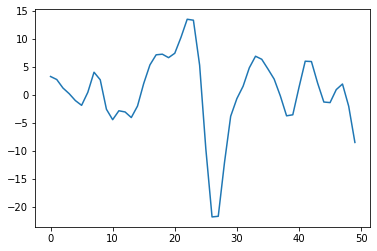

In [71]:
fig, ax = plt.subplots()
ax.plot(spike_trace)

NameError: name 'peak_aligned_spike_matrix' is not defined

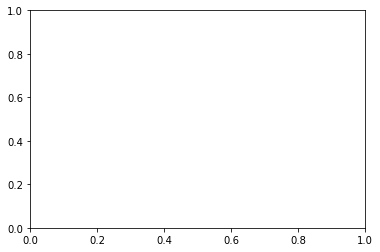

/home/timsit/.conda/envs/mecp2/lib/python3.7/site-packages/panel/pane/plot.py:103: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.object.canvas.print_figure(b, bbox_inches=bbox_inches)


In [14]:
fig, ax = plt.subplots()
ax.plot(np.mean(peak_aligned_spike_matrix, axis=0))

In [74]:
alignment_duration_frame

25.0

In [79]:
single_spike_frame

7499872.0

In [78]:
spike_neg_peak_frame

7499873

# Code to get the intersection matrix and get the unique spikes times

In [29]:
spike_dict = multiwavelet_dat['pre_TTX_mea_spike_struct']['channel_12']

In [31]:
spike_dict.items()

dict_items([('bior1p3', array([2741505., 2748775., 2819565., ..., 7499498., 7499730., 7499872.])), ('bior1p5', array([2741505., 2748776., 2819566., ..., 7499498., 7499734., 7499871.])), ('db2', array([ 661109., 2741508., 2748778., ..., 7499503., 7499732., 7499874.])), ('db3', array([2741510., 2748780., 2819570., ..., 7499501., 7499736., 7499875.])), ('haar', array([2741506., 2748775., 2819565., ..., 7499279., 7499356., 7499730.])), ('sym2', array([ 661109., 2741508., 2748778., ..., 7499503., 7499732., 7499874.]))])

In [50]:
all_spike_times = list()
fs = 25000
round_decimal_places = 3  # round to nearest 1 ms
for wname, spike_locs in spike_dict.items():
    all_spike_times.extend(spike_locs / fs)
    
if round_decimal_places is not None:
    all_spike_times = np.round(all_spike_times, round_decimal_places)
    
unique_spike_times = np.unique(all_spike_times)

In [47]:
np.shape(all_spike_times)

(98129,)

In [104]:
np.shape(intersection_matrix)

(23706, 6)

In [54]:
intersection_matrix = np.zeros((len(unique_spike_times), len(spike_dict.keys())))

In [82]:
np.sum(intersection_matrix, axis=1)

array([2., 6., 6., ..., 5., 6., 5.])

In [77]:
round_mode = 'decimal_places'
for n_wavelet, (wname, spike_locs) in enumerate(spike_dict.items()):

    spike_times = spike_locs / fs
    
    if round_decimal_places > 0:
        if round_mode == 'decimal_places':
            spike_times = np.round(spike_times, round_decimal_places)
        elif round_mode == 'nearest_to_value':
            print('Nearest to value not implemented yet')
            # round_targets = np.min(all_spike_times):round_decimal_places:max(all_spike_times)
            # spike_times = np.interp1(round_targets, round_targets, spike_times, 'nearest')
            # spike_times = floor(spike_times * 1/round_decimal_places) / (1 / round_decimal_places);
            
            
    wavelet_spike_in_unique_spikes = np.isin(unique_spike_times, spike_times)
    wavelet_spike_in_unique_spikes_idx = np.where(np.isin(unique_spike_times, spike_times))[0]
    intersection_matrix[wavelet_spike_in_unique_spikes_idx, n_wavelet] = 1
    
    #  for unq_spk_t_index in np.arange(len(unique_spike_times)):
    #     
     #    if np.isin(unique_spike_times[unq_spk_t_index], spike_times):
     #        intersection_matrix[unq_spk_t_index, n_wavelet] = 1
     

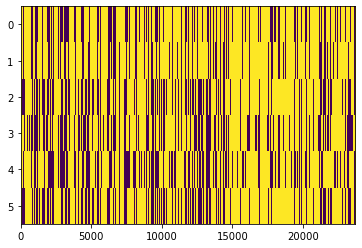

In [79]:
fig, ax = plt.subplots()
ax.imshow(intersection_matrix.T, aspect='auto')

In [67]:
unique_spike_times[unq_spk_t_index]

299.995

In [68]:
np.isin(unique_spike_times[unq_spk_t_index], spike_times)

array(True)

In [71]:
spike_times

array([ 26.444, 109.66 , 109.951, ..., 299.98 , 299.989, 299.995])

In [75]:
np.where(np.isin(unique_spike_times, spike_times))[0]

array([    0,     1,     2, ..., 23703, 23704, 23705])

In [76]:
len(np.where(np.isin(unique_spike_times, spike_times))[0])

16346

# PCA on detected spikes

In [161]:
unique_spike_waveforms = m_wavelet_dash.unique_spike_waveforms

In [162]:
np.shape(unique_spike_waveforms)

(23706, 50)

In [165]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
unique_spike_waveform_PCA = pca.fit_transform(unique_spike_waveforms)

In [166]:
np.shape(unique_spike_waveform_PCA)

(23706, 2)

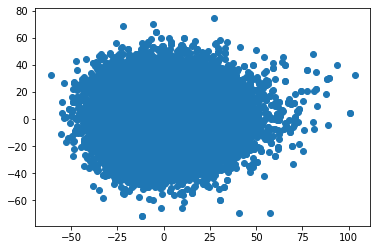

In [168]:
fig, ax = plt.subplots()
ax.scatter(unique_spike_waveform_PCA[:, 0], unique_spike_waveform_PCA[:, 1])

# Link PC scatter with plotting of waveform

In [206]:
unique_spike_waveform_PCA_df

,0,1
0,-19.983666,10.991883
1,3.552536,-12.824915
2,-14.854867,-7.051929
3,13.061695,-2.625029
4,-14.237477,-14.991183
...,...,...
23701,7.268827,22.039993
23702,-9.360408,-7.343503
23703,-5.248669,3.560177
23704,1.479569,30.320612


In [215]:
import bokeh.plotting as bokeh_plot
import bokeh.io as bokehio
from bokeh.layouts import row, gridplot
from bokeh.models import ColumnDataSource, CustomJS, TapTool
from bokeh.plotting import figure, show
from bokeh.layouts import gridplot
import bokeh.models as bkmodels
import bokeh.palettes as bkpalettes

import numpy as np

unique_spike_waveform_PCA_df = pd.DataFrame(unique_spike_waveform_PCA, columns=['PC1', 'PC2'])
data_source = bokeh_plot.ColumnDataSource(unique_spike_waveform_PCA_df)

tooltips = [
    ("PC 1 ", "@PC1"),
    ("PC 2", "@PC2"),
]

tools = "tap, hover, box_select, pan,wheel_zoom,box_zoom,reset"

p = bokeh_plot.figure(title="", 
                      x_axis_label='PC 1', 
                      y_axis_label='PC 2',
                      tools=tools, 
                      tooltips=tooltips)
p.scatter(x='PC1', 
          y='PC2', legend="Neuron", line_width=2,
          source=data_source)


waveform_plot_fig = bokeh_plot.figure(title="Spike waveform", 
                                      x_axis_label='Time bins',
                                      y_axis_label='Amplitude', tools=tools)

# show(p)

,PC1,PC2
0,-19.983666,10.991883
1,3.552536,-12.824915
2,-14.854867,-7.051929
3,13.061695,-2.625029
4,-14.237477,-14.991183
...,...,...
23701,7.268827,22.039993
23702,-9.360408,-7.343503
23703,-5.248669,3.560177
23704,1.479569,30.320612


In [201]:



# data_source = bokeh_plot.ColumnDataSource(audio_video_df.sort_values(by=['plane', 'cell']))

# subset data source
data_source = bokeh_plot.ColumnDataSource(audio_video_df.sort_values(by=['plane', 'cell'][0:4000]))
first_trial_audio_only_vector_list = first_trial_audio_only_vector_list[0:4000]
second_trial_audio_only_vector_list = second_trial_audio_only_vector_list[0:4000]
first_trial_video_only_vector_list = first_trial_video_only_vector_list[0:4000]
second_trial_video_only_vector_list = second_trial_video_only_vector_list[0:4000]

tooltips = [
    ("Plane", "@plane"), 
    ("Neuron", "@cell"),
    ("Audio correlation", "@audCorrScore"),
    ("Video correlation", "@visCorrScore"),
]

tools = "tap, hover, box_select, pan,wheel_zoom,box_zoom,reset"

p = bokeh_plot.figure(title="", 
                      x_axis_label='Video dependent correlation', 
                      y_axis_label='Audio dependent correlation',
                      tools=tools, 
                        tooltips=tooltips)
p.scatter(x='visCorrScore', 
          y='audCorrScore', legend="Neuron", line_width=2,
          source=data_source)

shared_line_data_source = ColumnDataSource({'x': np.arange(len(first_trial_audio_only_vector_list[0])),
                                            'trial_1_activity': first_trial_audio_only_vector_list[0],
                                           'trial_2_activity': second_trial_audio_only_vector_list[0],
                                           'trial_1_video_only_activity': first_trial_video_only_vector_list[0],
                                           'trial_2_video_only_activity': second_trial_video_only_vector_list[0],})

trial_1_corr_plot_fig = bokeh_plot.figure(title="Audio only repeat 1", x_axis_label='Stimulus aligned frames',
                                     y_axis_label='Activity', tools=tools)

"""
trial_1_corr_plot_line = trial_1_corr_plot_fig.line(x='x', y='Spikes',
                                                   source=ColumnDataSource({'x': np.arange(len(first_trial_audio_only_vector_list[0])),
                                                                            'Spikes': first_trial_audio_only_vector_list[10]}),
                                                    line_width=2)
"""
trial_1_corr_plot_line = trial_1_corr_plot_fig.line(x='x', y='trial_1_activity',
                                                   source=shared_line_data_source,
                                                    line_width=2)

trial_1_corr_plot_line = trial_1_corr_plot_fig.scatter(x='x', y='trial_1_activity',
                                                   source=shared_line_data_source,
                                                    size=0)

trial_1_corr_plot_line.visible = False


trial_2_corr_plot_fig = bokeh_plot.figure(title="Audio only repeat 2", x_axis_label='Stimulus aligned frames',
                                     y_axis_label='Activity', tools=tools)

"""
trial_2_corr_plot_line = trial_2_corr_plot_fig.line(x='x', y='Spikes',
                                                   source=ColumnDataSource({'x': np.arange(len(second_trial_audio_only_vector_list[0])),
                                                                            'Spikes': second_trial_audio_only_vector_list[10]}),
                                                   line_width=2)
"""
trial_2_corr_plot_line = trial_2_corr_plot_fig.line(x='x', y='trial_2_activity',
                                                   source=shared_line_data_source,
                                                    line_width=2)

# A scatter just for the linking, hidden by setting size to 0
trial_2_corr_plot_line = trial_2_corr_plot_fig.scatter(x='x', y='trial_2_activity',
                                                   source=shared_line_data_source,
                                                    size=0)


trial_2_corr_plot_line.visible = False


# Include video only plots as well 

video_only_trial_1_corr_plot_fig = bokeh_plot.figure(title="Video only repeat 1", x_axis_label='Stimulus aligned frames',
                                     y_axis_label='Activity', tools=tools)
video_only_trial_2_corr_plot_fig = bokeh_plot.figure(title="Video only repeat 2", x_axis_label='Stimulus aligned frames',
                                     y_axis_label='Activity', tools=tools)


video_only_trial_1_corr_plot_line = video_only_trial_1_corr_plot_fig.line(x='x', y='trial_1_video_only_activity',
                                                   source=shared_line_data_source,
                                                    line_width=2)

video_only_trial_2_corr_plot_line = video_only_trial_2_corr_plot_fig.line(x='x', y='trial_2_video_only_activity',
                                                   source=shared_line_data_source,
                                                    line_width=2)

video_only_trial_1_corr_plot_line = video_only_trial_1_corr_plot_fig.scatter(x='x', y='trial_1_video_only_activity',
                                                   source=shared_line_data_source,
                                                    size=0)

video_only_trial_2_corr_plot_line = video_only_trial_2_corr_plot_fig.scatter(x='x', y='trial_2_video_only_activity',
                                                   source=shared_line_data_source,
                                                    size=0)




code = '''if (cb_data.source.selected.indices.length > 0){
            trial_1_corr_plot_line.visible = true;
            trial_2_corr_plot_line.visible = true;
            selected_index = cb_data.source.selected.indices[0];
            trial_1_corr_plot_line.data_source.data['trial_1_activity'] = first_trial_audio_only_vector_list[selected_index]
            trial_1_corr_plot_line.data_source.change.emit(); 
            trial_2_corr_plot_line.data_source.data['trial_2_activity'] = second_trial_audio_only_vector_list[selected_index]
            trial_2_corr_plot_line.data_source.change.emit(); 
            
            video_only_trial_1_corr_plot_line.visible = true;
            video_only_trial_2_corr_plot_line.visible = true; 
            video_only_trial_1_corr_plot_line.data_source.data['trial_1_video_only_activity'] = first_trial_video_only_vector_list[selected_index]
            video_only_trial_1_corr_plot_line.data_source.change.emit();
            video_only_trial_2_corr_plot_line.data_source.data['trial_2_video_only_activity'] = second_trial_video_only_vector_list[selected_index]
            video_only_trial_2_corr_plot_line.data_source.change.emit();
          }'''



p.select(TapTool).callback = CustomJS(args = {'trial_1_corr_plot_line': trial_1_corr_plot_line,
                                             'first_trial_audio_only_vector_list': first_trial_audio_only_vector_list,
                                              'trial_2_corr_plot_line': trial_2_corr_plot_line, 
                                             'second_trial_audio_only_vector_list': second_trial_audio_only_vector_list,
                                              'video_only_trial_1_corr_plot_line': video_only_trial_1_corr_plot_line,
                                              'video_only_trial_2_corr_plot_line': video_only_trial_2_corr_plot_line,
                                              'first_trial_video_only_vector_list': first_trial_video_only_vector_list,
                                              'second_trial_video_only_vector_list': second_trial_video_only_vector_list
                                              }, code = code)



# Add axvspan to show video playback times 
left_locs = np.arange(0, 290, 10)
right_locs = np.arange(9, 290, 10)
for left_loc, right_loc, color in zip(left_locs, right_locs, bkpalettes.magma(len(right_locs))):
    trial_1_corr_plot_fig.add_layout(bkmodels.BoxAnnotation(left=left_loc, right=right_loc, fill_alpha=0.25, fill_color=color))
    trial_2_corr_plot_fig.add_layout(bkmodels.BoxAnnotation(left=left_loc, right=right_loc, fill_alpha=0.25, fill_color=color))
    # glyph = bkmodels.glyphs.Quad(left=left_loc, right=right_loc, bottom=0, top=10, fill_alpha=0.25, fill_color=color, line_alpha=0)
    # trial_2_corr_plot_fig.add_glyph(glyph)

for left_loc, right_loc, color in zip(left_locs, right_locs, bkpalettes.viridis(len(right_locs))):
    video_only_trial_1_corr_plot_fig.add_layout(bkmodels.BoxAnnotation(left=left_loc, right=right_loc, fill_alpha=0.25, fill_color=color))
    video_only_trial_2_corr_plot_fig.add_layout(bkmodels.BoxAnnotation(left=left_loc, right=right_loc, fill_alpha=0.25, fill_color=color))

    

# plots = row(p, trial_1_corr_plot_fig)
plots = gridplot([[p, trial_1_corr_plot_fig, video_only_trial_1_corr_plot_fig], [None, trial_2_corr_plot_fig, video_only_trial_2_corr_plot_fig]],
                sizing_mode="stretch_both")


# bokehio.show(plots)
# plots.height=400
# plots.width=800


bokehio.save(plots, filename='/home/timsit/msi-presentations/figures/filmworld/correlation/TS004_interval_corr_interactive_plot_stretch_both_first_4000.html')

NameError: name 'audio_video_df' is not defined